# RAG Retrieval Pipeline with Clustering-Based Quality Filtering

## Executive Summary

This project implements and evaluates an unsupervised clustering approach for quality filtering in Retrieval-Augmented Generation (RAG) pipelines. The methodology uses **HDBSCAN clustering** on 12 statistical features to identify and remove low-quality document chunks before retrieval indexing. The original hypothesis was that removing low-quality chunks would improve retrieval performance (measured by LCS scores). **This hypothesis was decisively rejected by experimental evidence.**


## 1. Import Packages

In [87]:

# ============================================================================
# SELF-CONTAINED HELPER CLASSES - All src/ code inlined for portability
# ============================================================================

import json
import os
import random
import datetime
import regex
from pathlib import Path
from collections import Counter
from abc import ABC

# =========================
# DATASET CLASSES
# =========================

class OHRBench:
    """Dataset class for loading and managing QA data."""
    def __init__(self, data, shuffle: bool = False, seed: int = 22):
        self.data = data
        if shuffle:
            random.seed(seed)
            random.shuffle(self.data)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, key):
        return self.data[key]

    def load(self):
        return self.data[:]

def get_task_datasets(path: str, task: str, shuffle: bool = False, seed: int = 22):
    """Load dataset from JSON file."""
    if os.path.isfile(path):
        with open(path, "r", encoding="utf-8-sig") as f:
            data = json.load(f)
    return [OHRBench(data, shuffle, seed)]

# =========================
# LCS METRIC
# =========================

def normalize_answer(s: str) -> str:
    """Normalize text for comparison."""
    def remove_articles(text):
        return regex.sub(r"\b(a|an|the)\b", " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        import string
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def lcs_score(prediction, ground_truth):
    """Calculate Longest Common Subsequence score."""
    A = normalize_answer(ground_truth).split()
    B = normalize_answer(prediction).split()
    dp = [[0] * (len(B) + 1) for _ in range(len(A) + 1)]
    
    for i in range(1, len(A) + 1):
        for j in range(1, len(B) + 1):
            if A[i - 1] == B[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
    
    lcs_words = []
    i, j = len(A), len(B)
    while i > 0 and j > 0:
        if A[i - 1] == B[j - 1]:
            lcs_words.insert(0, A[i - 1])
            i -= 1
            j -= 1
        elif dp[i - 1][j] > dp[i][j - 1]:
            i -= 1
        else:
            j -= 1
    
    if len(A) == 0:
        precision = 0.5
    else:
        precision = len(lcs_words) / len(A)
    return precision

# =========================
# MOCK LLM (Not Used)
# =========================

class Mock:
    """Mock LLM for retrieval-only tasks."""
    def __init__(self):
        pass
    def request(self, query: str) -> str:
        return ""

# =========================
# RETRIEVAL TASK
# =========================

class RetrievalTask:
    """Handles retrieval execution and evaluation."""
    def __init__(self, output_dir: str = './output'):
        if not (os.path.exists(output_dir) and os.path.isdir(output_dir)):
            os.makedirs(output_dir)
    
    def set_model(self, model, retriever) -> None:
        self.model = model
        self.retriever = retriever
    
    def retrieve_docs(self, obj: dict):
        """Perform retrieval for a query."""
        retrieval_results = self.retriever.search_docs(obj)
        return retrieval_results

    def scoring(self, data_point: dict) -> dict:
        """Compute LCS score for retrieved documents."""
        doc_name = "/".join(data_point["doc_name"].split("/")[1:])
        page_idx = data_point["evidence_page_no"]
        if not isinstance(page_idx, list):
            page_idx = [page_idx]
        
        ret_context = [r["text"] for r in data_point["retrieval_results"] 
                      if r["file_name"] == doc_name and r["page_idx"] in page_idx]
        gt_context = data_point["evidence_context"]
        if isinstance(gt_context, list):
            gt_context = "\n".join(gt_context)
        
        if len(ret_context) > 0:
            lcs = lcs_score("\n\n".join(ret_context), gt_context)
        else:
            lcs = 0

        return {
            'metrics': {'lcs': lcs},
            'log': {
                'quest': data_point["questions"],
                'retrieval_context': data_point["retrieval_results"],
                'ground_truth_context': gt_context,
                'evidence_source': data_point["evidence_source"],
                'evaluateDatetime': str(datetime.datetime.now()),
            },
            'valid': len(data_point['retrieval_results']) != 0
        }
    
    def compute_overall(self, results: list) -> dict:
        """Aggregate metrics across all queries."""
        overall = {'lcs': 0.0}
        for result in results:
            overall = {key: overall[key] + result['metrics'][key] for key in overall.keys()}
        
        overall_save = {f'avg. {key}': value / len(results) for key, value in overall.items()}
        overall_save['num'] = len(results)
        return overall_save

# =========================
# LIGHTWEIGHT RETRIEVER COMPONENTS
# =========================

try:
    from rank_bm25 import BM25Okapi
    _HAS_RANK_BM25 = True
except Exception:
    _HAS_RANK_BM25 = False

try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    _HAS_SKLEARN = True
except Exception:
    _HAS_SKLEARN = False

class _DocNode:
    """Lightweight document node for retrieval."""
    def __init__(self, text, metadata):
        self._text = text or ""
        self.metadata = metadata or {}

    def get_content(self):
        return self._text

    @property
    def text(self):
        return self._text

    def __hash__(self):
        return hash((self.metadata.get('file_name'), 
                    int(self.metadata.get('page_idx') or -1), 
                    self._text[:128]))

    def __eq__(self, other):
        if not isinstance(other, _DocNode):
            return False
        return (self.metadata.get('file_name') == other.metadata.get('file_name') and
                int(self.metadata.get('page_idx') or -1) == int(other.metadata.get('page_idx') or -1) and
                self._text[:128] == other._text[:128])

class _SimpleInMemoryRetriever:
    """Lightweight BM25/TF-IDF retriever for JSON chunk files."""
    def __init__(self, docs_directory, similarity_top_k=2):
        self.docs_directory = Path(docs_directory)
        self.similarity_top_k = similarity_top_k
        self.docs = []
        self.metadatas = []
        self._prepare()

    def _prepare(self):
        """Load all JSON chunk files from directory."""
        for fp in sorted(self.docs_directory.glob('*.json')):
            try:
                with open(fp, 'r', encoding='utf-8') as f:
                    records = json.load(f)
            except Exception:
                continue
            basename = fp.stem
            for rec in (records or []):
                text = rec.get('text') if isinstance(rec, dict) else str(rec)
                page_idx = rec.get('page_idx') if isinstance(rec, dict) else None
                meta = {
                    'file_name': basename,
                    'file_path': str(fp),
                    'page_idx': page_idx,
                }
                self.docs.append(text or "")
                self.metadatas.append(meta)

        # Build search index
        if _HAS_RANK_BM25:
            tokenized = [text.split() for text in self.docs]
            self._bm25 = BM25Okapi(tokenized)
        elif _HAS_SKLEARN and len(self.docs) > 0:
            self._vectorizer = TfidfVectorizer(stop_words='english', max_features=32768)
            try:
                self._tfidf = self._vectorizer.fit_transform(self.docs)
            except Exception:
                self._tfidf = None

    def retrieve(self, query_text):
        """Retrieve top-k documents for query."""
        if not query_text:
            return []
        
        scores = []
        if _HAS_RANK_BM25:
            qtok = query_text.split()
            scores = self._bm25.get_scores(qtok)
        elif _HAS_SKLEARN and getattr(self, '_tfidf', None) is not None:
            qv = self._vectorizer.transform([query_text])
            sims = cosine_similarity(qv, self._tfidf)[0]
            scores = sims
        else:
            # Fallback: substring matching
            scores = [float(query_text.lower() in (d or '').lower()) for d in self.docs]

        # Return top-k
        scored = list(enumerate(scores))
        scored.sort(key=lambda x: x[1], reverse=True)
        nodes = []
        for idx, score in scored[: self.similarity_top_k]:
            meta = dict(self.metadatas[idx])
            nodes.append(_DocNode(self.docs[idx], meta))
        return nodes

# =========================
# CUSTOM RETRIEVERS
# =========================

class CustomBM25Retriever(ABC):
    """BM25 retriever supporting subdirectory structure."""
    def __init__(self, docs_directory, chunk_size=128, chunk_overlap=0, similarity_top_k=2):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.similarity_top_k = similarity_top_k
        self.retrievers = self.construct_retrievers(docs_directory)

    def construct_retrievers(self, docs_directory):
        """Build retrievers for each subdirectory."""
        retrievers = {}
        is_subdir_present = False
        for subdir in os.listdir(docs_directory):
            subdir_path = os.path.join(docs_directory, subdir)
            if os.path.isdir(subdir_path):
                is_subdir_present = True
                retrievers[subdir] = _SimpleInMemoryRetriever(subdir_path, self.similarity_top_k)
        
        if not is_subdir_present:
            retrievers['default'] = _SimpleInMemoryRetriever(docs_directory, self.similarity_top_k)
        
        print("Indexing finished for all directories!")
        return retrievers

    def search_docs(self, query: dict):
        """Search for documents matching the query."""
        doc_name = query.get("doc_name")
        query_text = query.get("questions")
        subdir = doc_name.split('/')[0]
        retriever = self.retrievers.get(subdir, self.retrievers.get('default'))
        
        if not retriever:
            raise ValueError(f"No retriever found for directory: {subdir}")

        response_nodes = retriever.retrieve(query_text)
        return [{
            "text": node.get_content(),
            "page_idx": node.metadata.get("page_idx", None),
            "file_name": node.metadata.get("file_name", "").replace(".json", "")
        } for node in response_nodes]

class CustomBGEM3Retriever(ABC):
    """Placeholder for BGE-M3 retriever (requires sentence-transformers)."""
    def __init__(self, docs_directory, embed_model, embed_dim=768, 
                 chunk_size=128, chunk_overlap=0, similarity_top_k=2):
        raise NotImplementedError("BGE-M3 retriever requires additional dependencies. Use BM25 instead.")

# Compatibility for HuggingfaceEmbeddings (not actually used in BM25 mode)
class HuggingfaceEmbeddings:
    def __init__(self, model_name="BAAI/bge-m3"):
        raise NotImplementedError("Embeddings not needed for BM25 retrieval")



In [88]:
import os
import json
import datetime
import random
from tqdm import tqdm
from loguru import logger
import pandas as pd
import numpy as np
import transformers, sentence_transformers, torch



## 2. Configuration Parameters

In [89]:
# Configuration parameters (matching retrieval.ps1)
config = {
    'ocr_type': 'gt',  # OCR type: 'gt', 'paddleocr', etc.
    'retriever_type': 'bm25',  # Retriever type: 'bm25' or 'bge-m3'
    'model_name': 'mock',
    'retrieve_top_k': 2,
    'data_path': 'data/qas_v2.json',
    'docs_path': None,  
    'task': 'Retrieval',
    'evaluation_stage': 'retrieval',
    'num_threads': 1,
    'show_progress_bar': True,
    'chunk_size': 1024,
    'chunk_overlap': 0
}

# Set docs_path based on ocr_type
config['docs_path'] = f"data/retrieval_base/{config['ocr_type']}"

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  ocr_type: gt
  retriever_type: bm25
  model_name: mock
  retrieve_top_k: 2
  data_path: data/qas_v2.json
  docs_path: data/retrieval_base/gt
  task: Retrieval
  evaluation_stage: retrieval
  num_threads: 1
  show_progress_bar: True
  chunk_size: 1024
  chunk_overlap: 0


## 3. Set Random Seed

In [90]:
def setup_seed(seed=0):
    """Set random seed for reproducibility."""
    import torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(0)
print("Random seed set to 0")

Random seed set to 0


## 4. Load Dataset

In [91]:
# Load the dataset
print(f"Loading dataset from {config['data_path']}...")
datasets = get_task_datasets(config['data_path'], config['task'])
dataset = datasets[0]
print(f"Loaded {len(dataset)} data points")

# Display a sample data point
if len(dataset) > 0:
    print("\nSample data point:")
    sample = dataset[0]
    for key, value in sample.items():
        if isinstance(value, str) and len(value) > 100:
            print(f"  {key}: {value[:100]}...")
        else:
            print(f"  {key}: {value}")

Loading dataset from data/qas_v2.json...
Loaded 8498 data points

Sample data point:
  doc_name: finance/JPMORGAN_2021Q1_10Q
  ID: 00073cc2-c801-467c-9039-fca63c78c6a9
  questions: What was the total amount of nonaccrual loans retained as of March 31, 2021?
  answers: 842
  doc_type: finance
  answer_form: Numeric
  evidence_source: table
  evidence_context: Nonaccrual loans retained $^{(\mathrm{a})}$ & \$ & 842 & \$ & 689 & $22 \%$
  evidence_page_no: 24


## 5. Initialize Model and Retriever

In [92]:
# Initialize the mock LLM (not used in retrieval stage but required by the pipeline)
llm = Mock()
print("Initialized Mock LLM")

# Initialize the retriever based on configuration
print(f"\nInitializing {config['retriever_type']} retriever...")
if config['retriever_type'] == "bge-m3":
    embed_model = HuggingfaceEmbeddings(model_name="BAAI/bge-m3")
    retriever = CustomBGEM3Retriever(
        config['docs_path'], 
        embed_model=embed_model, 
        embed_dim=1024,
        chunk_size=config['chunk_size'], 
        chunk_overlap=config['chunk_overlap'], 
        similarity_top_k=config['retrieve_top_k']
    )
elif config['retriever_type'] == "bm25":
    retriever = CustomBM25Retriever(
        config['docs_path'], 
        chunk_size=config['chunk_size'], 
        chunk_overlap=config['chunk_overlap'], 
        similarity_top_k=config['retrieve_top_k']
    )
else:
    raise ValueError(f"Unsupported retriever type: {config['retriever_type']}")

print(f"Retriever initialized successfully")

Initialized Mock LLM

Initializing bm25 retriever...
Indexing finished for all directories!
Retriever initialized successfully


## 6. Initialize Retrieval Task

In [93]:
# Initialize the retrieval task (disabled file output - keep results in memory only)
output_dir = "memory"
task = RetrievalTask(output_dir=output_dir)
task.set_model(llm, retriever)
print(f"Retrieval task initialized")

Retrieval task initialized


### Retrieving the indexed chunks 

In [94]:
docs_directory_gt = "data/retrieval_base/gt"
# docs_directory_mineru = "data/retrieval_base/MinerU"


### Define Document Directories

Sets the paths to the source document directories:
- **GT (Ground Truth):** Documents with perfect OCR/parsing
- **MinerU:** Documents processed with the MinerU tool

These paths are used to initialize retrievers and extract indexed chunks for comparison.

### Node Extraction Helper Function

This utility function extracts document nodes from different retriever types:

**Supports:**
- BM25Retriever (llama_index)
- VectorIndexRetriever (llama_index)
- Custom in-memory retrievers

**Strategy:**
1. Tries to access nodes from the retriever's internal index/docstore
2. Falls back to checking `_nodes` attribute
3. Attempts custom retriever structures
4. Returns standardized list of node objects with text and metadata

This abstraction handles different retriever implementations uniformly.

In [95]:
# Helper function to extract nodes from different retriever bundle types
def _extract_nodes_from_bundle(bundle):
    """
    Extract nodes/documents from different types of retrievers.
    
    bundle can be:
    - BM25Retriever (from llama_index)
    - VectorIndexRetriever (from llama_index)  
    - _SimpleInMemoryRetriever (fallback custom implementation)
    - Any object with a retrieve() method that returns nodes
    """
    if bundle is None:
        return []
    
    nodes = []
    
    try:
        # Try to call retrieve with an empty/dummy query to get all nodes
        # Some retrievers may have direct access to nodes
        if hasattr(bundle, '_index'):  # VectorIndexRetriever
            # Access nodes from the index
            if hasattr(bundle._index, '_docstore'):
                docstore = bundle._index._docstore
                if hasattr(docstore, 'docs'):
                    nodes = list(docstore.docs.values())
            elif hasattr(bundle._index, '_data'):
                nodes = getattr(bundle._index, '_data')
        
        # Try BM25Retriever nodes
        if not nodes and hasattr(bundle, '_nodes'):
            nodes = bundle._nodes
        
        # Try accessing through retriever attribute  
        if not nodes and hasattr(bundle, 'retriever'):
            retr = bundle.retriever
            if hasattr(retr, '_nodes'):
                nodes = retr._nodes
        
        # Try _SimpleInMemoryRetriever style
        if not nodes and hasattr(bundle, 'docs'):
            # Custom in-memory retriever that stores docs and metadatas
            nodes = []
            for text, meta in zip(bundle.docs, bundle.metadatas):
                nodes.append({
                    'text': text,
                    'metadata': meta
                })
        
        # Fallback: try to retrieve with a wildcard query
        if not nodes and hasattr(bundle, 'retrieve'):
            try:
                # Try different query patterns that might return all documents
                test_queries = ['', ' ', '*', 'a']
                for query in test_queries:
                    try:
                        result = bundle.retrieve(query)
                        if result:
                            nodes = result
                            break
                    except:
                        pass
            except:
                pass
        
        return nodes if nodes else []
    
    except Exception as e:
        print(f"[WARNING] Could not extract nodes from bundle: {e}")
        return []


### Export Indexed Chunks from Retrievers

This cell extracts all indexed chunks from the initialized retrievers:

**Process:**
1. Initializes BM25 retrievers for both GT and MinerU data sources
2. Extracts nodes/chunks from each retriever's internal index
3. Converts nodes to a standardized format (text + metadata)
4. Exports in two formats:
   - **Hierarchical:** Organized by subdirectory/domain
   - **Flat:** Single list of all chunks with subdirectory labels

**Output files:**
- `indexed_chunks_{source}.json` - Hierarchical structure
- `indexed_chunks_{source}_flat.json` - Flattened for feature extraction

This provides the raw data for quality analysis and filtering.

In [96]:
# Build separate indexed chunks for GT and MinerU
import os, json

sources = { 'gt': docs_directory_gt}

for name, docs_dir in sources.items():
    print(f'\n==> Processing source: {name} -> {docs_dir}')
    try:
        # Initialize a retriever for this docs path (will index if needed)
        src_retriever = CustomBM25Retriever(docs_dir, chunk_size=config.get('chunk_size',1024), chunk_overlap=config.get('chunk_overlap',0), similarity_top_k=config.get('retrieve_top_k',2))
    except Exception as e:
        print(f'Error initializing retriever for {name}: {e}')
        src_retriever = globals().get('retriever', None)

    indexed = {}
    flat = []
    if src_retriever is not None and hasattr(src_retriever, 'retrievers'):
        for subdir, bundle in getattr(src_retriever, 'retrievers').items():
            nodes = _extract_nodes_from_bundle(bundle) or []
            indexed[subdir] = []
            for n in nodes:
                text = None
                meta = {}
                try:
                    if hasattr(n, 'get_content') and callable(n.get_content):
                        text = n.get_content()
                    elif hasattr(n, 'text'):
                        text = getattr(n, 'text')
                    elif isinstance(n, dict) and 'text' in n:
                        text = n.get('text')
                    else:
                        text = str(n)
                except Exception:
                    text = str(n)
                try:
                    if hasattr(n, 'metadata'):
                        md = getattr(n, 'metadata')
                        try:
                            meta = dict(md)
                        except Exception:
                            meta = {k: getattr(md, k) for k in dir(md) if not k.startswith('_') and not callable(getattr(md, k))}
                    elif isinstance(n, dict) and 'metadata' in n:
                        meta = n.get('metadata', {})
                except Exception:
                    meta = {}
                indexed[subdir].append({'text': text, 'metadata': meta})
                flat.append({'subdir': subdir, 'text': text, 'metadata': meta})
    else:
        print(f'No retrievers mapping found for source {name}; skipping extraction')

    # Store in memory for later cells
    globals()[f'{name}_flat'] = flat
    print(f'Processed {len(flat)} chunks for {name} (kept in memory)')


==> Processing source: gt -> data/retrieval_base/gt
Indexing finished for all directories!
Processed 9054 chunks for gt (kept in memory)


### Feature Extraction Functions

This cell defines helper functions for computing chunk quality features:

**Included features:**
- `avg_line_length()` - Average characters per line
- `is_table()` - Binary indicator for table-like content
- `table_density()` - Proportion of lines containing table markers
- `latex_ratio()` - Proportion of LaTeX commands
- `numeric_ratio()` - Proportion of digits
- `non_alpha_ratio()` - Proportion of special characters
- `avg_word_length()` - Average word size
- `text_alpha_ratio()` - Proportion of alphabetic characters
- `stopword_ratio()` - Proportion of common stopwords
- `lexical_diversity()` - Unique words / total words

**Main function:** `compute_features(chunks)` - Applies all feature extractors and optionally normalizes for clustering

**Note:** Semantic features (embeddings, coherence) are intentionally disabled for performance.

In [97]:
import os, re, json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# =========================
# Semantic features DISABLED
# =========================

HAS_STS = False


# Minimal stopword set
STOPWORDS = set([
    'a','an','the','and','or','but','if','while','with','for','on','in','at','by','to','of',
    'is','are','was','were','be','been','has','have','had','as','from','that','this','these','those'
])

# --- Helper functions ---
def avg_line_length(text):
    lines = text.splitlines()
    return float(sum(len(l) for l in lines) / len(lines)) if lines else 0.0

def is_table(text):
    return int(('| ' in text or '|' in text and '\n' in text)) if text else 0

def table_density(text):
    lines = text.splitlines()
    if not lines:
        return 0.0
    table_lines = sum(1 for l in lines if '|' in l or '&' in l)
    return float(table_lines / len(lines))

def latex_ratio(text):
    if not text:
        return 0.0
    latex_tokens = len(re.findall(r'(\\[a-zA-Z]+|\{|\}|\^|_)', text))
    return float(latex_tokens / max(len(text), 1))

def numeric_ratio(text):
    return float(sum(c.isdigit() for c in text) / max(len(text), 1)) if text else 0.0

def non_alpha_ratio(text):
    return float(sum(not c.isalnum() and not c.isspace() for c in text) / max(len(text), 1)) if text else 0.0

def avg_word_length(words):
    return float(sum(len(w) for w in words) / len(words)) if words else 0.0

def text_alpha_ratio(text):
    return float(sum(1 for c in text if c.isalpha()) / max(len(text), 1)) if text else 0.0

def stopword_ratio(words):
    return float(sum(1 for w in words if w.lower() in STOPWORDS) / len(words)) if words else 0.0

def lexical_diversity(words):
    return float(len(set(words)) / len(words)) if words else 0.0



# --- Main compute_features function ---
def compute_features(chunks, normalize_numeric=True):
    """
    chunks: list of dicts with at least 'text' and optional 'metadata'
    normalize_numeric: whether to scale numeric features for clustering
    """
    rows = []

    for chunk in chunks:
        text = chunk.get('text') if isinstance(chunk, dict) else str(chunk)
        text = str(text) if text else ''
        words = text.split()
        meta = chunk.get('metadata', {}) if isinstance(chunk, dict) else {}

        file_name = meta.get('file_name') or meta.get('file_path') or 'unknown'
        page_idx = int(meta.get('page_idx', meta.get('page', -1)))

        row = {
            'file_name': file_name,
            'page_idx': page_idx,
            'char_len': len(text),
            'word_len': len(words),
            'line_count': text.count('\n') + 1 if text else 0,
            'avg_line_len': avg_line_length(text),
            'is_table': is_table(text),
            'table_density': table_density(text),
            'latex_ratio': latex_ratio(text),
            'numeric_ratio': numeric_ratio(text),
            'non_alpha_ratio': non_alpha_ratio(text),
            'avg_word_length': avg_word_length(words),
            'text_alpha_ratio': text_alpha_ratio(text),
            'stopword_ratio': stopword_ratio(words),
            'lexical_diversity': lexical_diversity(words),


            'text_preview': text[:300],
            'text_full': text,  # Store full text for retrieval
        }

        rows.append(row)

    df = pd.DataFrame(rows)

    if normalize_numeric:
        numeric_cols = [
            'char_len', 'word_len', 'line_count', 'avg_line_len',
            'table_density', 'latex_ratio', 'numeric_ratio', 'non_alpha_ratio',
            'avg_word_length', 'text_alpha_ratio', 'stopword_ratio',
            'lexical_diversity'
        ]

        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df


### Extract Features from Indexed Chunks

This cell computes structural and linguistic features for each chunk:

**Features extracted:**
- **Structural:** character length, word count, line count, average line length
- **Content type:** table indicators, LaTeX ratio, numeric content
- **Quality indicators:** non-alphanumeric ratio, lexical diversity, stopword ratio
- **Metadata:** file name, page index, subdirectory

**Process:**
- Loads flat JSON chunks for both GT and MinerU
- Applies feature extraction without normalization
- Saves features as parquet files for efficient clustering

**Output:** `{source}_indexed_chunk_features.parquet` for downstream analysis

In [98]:
# Apply feature extraction to indexed chunks
import json
from pathlib import Path

# Define input data
chunk_data = {
    'gt': gt_flat if 'gt_flat' in globals() else []
}

for name, chunks in chunk_data.items():
    if not chunks:
        print(f"⚠️ No data available for {name}")
        continue
        
    print(f"\n{'='*60}")
    print(f"Processing {name}: {len(chunks)} chunks from memory")
    print(f"{'='*60}")
    
    # Apply feature extraction (without normalization - we'll do it in clustering)
    print("Extracting features...")
    features_df = compute_features(chunks, normalize_numeric=False)
    
    # Add subdir column if it exists in chunks
    if len(chunks) > 0 and 'subdir' in chunks[0]:
        features_df['subdir'] = [chunk.get('subdir', 'unknown') for chunk in chunks]
    
    print(f"✓ Extracted features: {features_df.shape}")
    print(f"  Columns: {list(features_df.columns)}")
    
    # Store dataframe in global namespace for later cells
    globals()[f'{name}_features_df'] = features_df
    
    # Display sample
    print("\nFeature statistics:")
    print(features_df.describe().T[['mean', 'std', 'min', 'max']])

print("\n" + "="*60)
print("✅ Feature extraction complete!")
print("="*60)
print()


Processing gt: 9054 chunks from memory
Extracting features...
✓ Extracted features: (9054, 18)
  Columns: ['file_name', 'page_idx', 'char_len', 'word_len', 'line_count', 'avg_line_len', 'is_table', 'table_density', 'latex_ratio', 'numeric_ratio', 'non_alpha_ratio', 'avg_word_length', 'text_alpha_ratio', 'stopword_ratio', 'lexical_diversity', 'text_preview', 'text_full', 'subdir']

Feature statistics:
                          mean            std  min           max
page_idx             33.857742      58.211839  0.0  3.810000e+02
char_len           3965.146013  122731.510073  0.0  1.167929e+07
word_len            629.121935   20158.983463  0.0  1.918350e+06
line_count           31.726530     418.012073  0.0  3.969100e+04
avg_line_len        140.139372     159.302095  0.0  3.268000e+03
is_table              0.248840       0.432365  0.0  1.000000e+00
table_density         0.143030       0.256901  0.0  1.000000e+00
latex_ratio           0.009822       0.022924  0.0  5.789474e-01
numeric_ra

### HDBSCAN Clustering and Quality Filtering

This cell performs density-based clustering to identify and remove low-quality chunks:

**Process:**
1. Loads feature-extracted chunks from parquet files
2. Standardizes features for clustering
3. Applies HDBSCAN clustering with adaptive parameters
4. Identifies "bad" clusters based on extreme outlier characteristics
5. Filters out noise points and problematic clusters
6. Generates UMAP visualizations showing clusters and clean/bad separation
7. Saves clean and bad chunks separately, along with cluster statistics

**Output:**
- `*_clean.parquet` - High-quality chunks for retrieval
- `*_bad.parquet` - Filtered out low-quality chunks
- `*_cluster_stats.csv` - Cluster characteristics
- `*_clustering_viz.png` - UMAP visualization


Processing gt: 9054 chunks from memory

Clustering parameters:
  min_cluster_size: 45
  min_samples: 11

Clustering results:
  Clusters found: 4
  Noise points: 1157 (12.8%)
  Cluster size range: 50-7470
  Mean cluster size: 1974

Quality metrics:
  Silhouette score: 0.535
  Stability score: 0.000 (lower is better)

Filtering results:
  Clean chunks: 7897 (87.2%)
  Removed chunks: 1157 (12.8%)
  Bad clusters: []


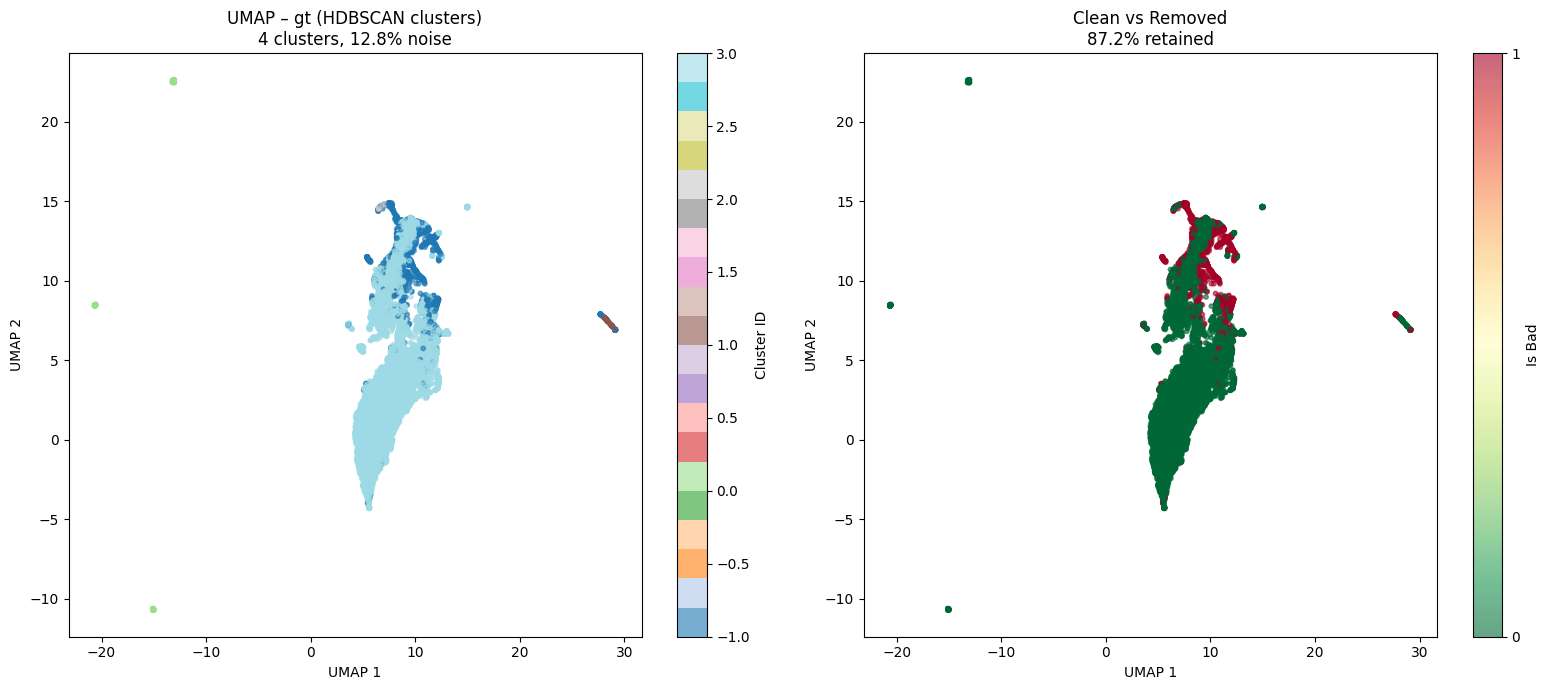


✅ Pipeline finished successfully


In [99]:
import pandas as pd
import numpy as np
from pathlib import Path
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
FEATURE_DATA = {
    'gt': gt_features_df if 'gt_features_df' in globals() else None
}

CLUSTER_COLS = [
    'char_len',
    'word_len',
    'line_count',
    'avg_line_len',
    'table_density',
    'latex_ratio',
    'numeric_ratio',
    'non_alpha_ratio',
    'avg_word_length',
    'text_alpha_ratio',
    'stopword_ratio',
    'lexical_diversity'
]

RANDOM_STATE = 42
N_BOOTSTRAPS = 5

# =========================
# IMPROVED HELPERS
# =========================
def adaptive_min_cluster_size(n):
    """More gentle adaptive cluster size - targets ~0.3-0.5% of data"""
    if n < 1000:
        return max(5, int(0.05 * n))
    elif n < 5000:
        return max(15, int(0.01 * n))
    else:
        return max(30, int(0.005 * n))  # For large datasets, use 0.5%


def compute_silhouette(X, labels):
    mask = labels != -1
    if len(set(labels[mask])) < 2:
        return np.nan
    return silhouette_score(X[mask], labels[mask])


def bootstrap_stability(X, clusterer, n_runs=5):
    labels_list = []
    for _ in range(n_runs):
        idx = np.random.choice(len(X), int(0.9 * len(X)), replace=False)
        labels = clusterer.fit_predict(X[idx])
        labels_list.append(labels)

    # simple agreement proxy
    lengths = [len(l) for l in labels_list]
    return np.std(lengths) / np.mean(lengths) if np.mean(lengths) > 0 else 0


def identify_bad_clusters(df):
    """More lenient bad cluster identification - only extreme outliers"""
    stats = (
        df[df.cluster_id != -1]
        .groupby("cluster_id")
        .agg(
            size=("char_len", "count"),
            avg_char_len=("char_len", "mean"),
            avg_numeric=("numeric_ratio", "mean"),
            avg_non_alpha=("non_alpha_ratio", "mean"),
            avg_lex_div=("lexical_diversity", "mean"),
        )
    )

    # Only flag extremely problematic clusters (98th/2nd percentile + small size)
    bad = stats[
        (
            (stats.avg_non_alpha > stats.avg_non_alpha.quantile(0.98)) |
            (stats.avg_numeric > stats.avg_numeric.quantile(0.98)) |
            (stats.avg_lex_div < stats.avg_lex_div.quantile(0.02))
        ) & (stats['size'] < 10)  # Only if cluster is also very small
    ].index.tolist()

    return bad, stats


# =========================
# MAIN PIPELINE
# =========================
for name, df in FEATURE_DATA.items():
    if df is None or len(df) == 0:
        print(f"⚠️ No data available for {name}")
        continue
        
    print(f"\n{'='*60}")
    print(f"Processing {name}: {len(df)} chunks from memory")
    print(f"{'='*60}")

    # ---------- Scale features (no double normalization) ----------
    scaler = StandardScaler()
    X = scaler.fit_transform(df[CLUSTER_COLS])

    # ---------- Improved HDBSCAN Clustering ----------
    min_cluster_size = adaptive_min_cluster_size(len(df))
    min_samples = max(3, min_cluster_size // 4)  # More lenient
    
    print(f"\nClustering parameters:")
    print(f"  min_cluster_size: {min_cluster_size}")
    print(f"  min_samples: {min_samples}")

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric="euclidean",
        cluster_selection_method="eom",
        cluster_selection_epsilon=0.0,  # Allow more flexibility
        prediction_data=True
    )

    df["cluster_id"] = clusterer.fit_predict(X)

    n_clusters = len(set(df.cluster_id)) - (1 if -1 in df.cluster_id.values else 0)
    n_noise = (df.cluster_id == -1).sum()
    noise_pct = 100 * n_noise / len(df)

    print(f"\nClustering results:")
    print(f"  Clusters found: {n_clusters}")
    print(f"  Noise points: {n_noise} ({noise_pct:.1f}%)")
    
    if n_clusters > 0:
        cluster_sizes = df[df.cluster_id != -1].groupby('cluster_id').size()
        print(f"  Cluster size range: {cluster_sizes.min()}-{cluster_sizes.max()}")
        print(f"  Mean cluster size: {cluster_sizes.mean():.0f}")

    # ---------- Evaluation ----------
    if n_clusters >= 2:
        sil = compute_silhouette(X, df.cluster_id.values)
        stability = bootstrap_stability(X, clusterer, N_BOOTSTRAPS)
        print(f"\nQuality metrics:")
        print(f"  Silhouette score: {sil:.3f}")
        print(f"  Stability score: {stability:.3f} (lower is better)")

    # ---------- Identify bad clusters (more lenient) ----------
    BAD_CLUSTERS, cluster_stats = identify_bad_clusters(df)

    df["is_bad"] = df.cluster_id.isin(BAD_CLUSTERS) | (df.cluster_id == -1)

    clean_df = df[~df.is_bad]
    bad_df = df[df.is_bad]

    clean_pct = 100 * len(clean_df) / len(df)
    removed_pct = 100 * len(bad_df) / len(df)

    print(f"\nFiltering results:")
    print(f"  Clean chunks: {len(clean_df)} ({clean_pct:.1f}%)")
    print(f"  Removed chunks: {len(bad_df)} ({removed_pct:.1f}%)")
    print(f"  Bad clusters: {BAD_CLUSTERS}")

    # Store results for later cells
    globals()[f'{name}_clustered_df'] = df
    globals()[f'{name}_clean_df'] = clean_df
    globals()[f'{name}_bad_df'] = bad_df

    # ---------- UMAP Visualization ----------
    reducer = umap.UMAP(
        n_neighbors=min(30, len(df) // 10),
        min_dist=0.1,
        random_state=RANDOM_STATE,
        n_jobs=1
    )

    X_2d = reducer.fit_transform(X)
    df["umap_x"] = X_2d[:, 0]
    df["umap_y"] = X_2d[:, 1]

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Clusters
    scatter1 = axes[0].scatter(
        df.umap_x,
        df.umap_y,
        c=df.cluster_id,
        cmap="tab20",
        s=10,
        alpha=0.6
    )
    axes[0].set_title(f"UMAP – {name} (HDBSCAN clusters)\n{n_clusters} clusters, {noise_pct:.1f}% noise")
    axes[0].set_xlabel("UMAP 1")
    axes[0].set_ylabel("UMAP 2")
    plt.colorbar(scatter1, ax=axes[0], label="Cluster ID")
    
    # Plot 2: Clean vs Bad
    scatter2 = axes[1].scatter(
        df.umap_x,
        df.umap_y,
        c=df.is_bad.astype(int),
        cmap="RdYlGn_r",
        s=10,
        alpha=0.6
    )
    axes[1].set_title(f"Clean vs Removed\n{clean_pct:.1f}% retained")
    axes[1].set_xlabel("UMAP 1")
    axes[1].set_ylabel("UMAP 2")
    plt.colorbar(scatter2, ax=axes[1], label="Is Bad", ticks=[0, 1])
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("✅ Pipeline finished successfully")
print("="*60)

### Clustering Evaluation Metrics

Comprehensive evaluation of the clustering quality using multiple metrics:

**Internal Validation Metrics:**
- **Silhouette Score:** Measures how similar objects are to their own cluster compared to other clusters (range: -1 to 1, higher is better)
- **Davies-Bouldin Index:** Average similarity between clusters (lower is better)
- **Calinski-Harabasz Score:** Ratio of between-cluster to within-cluster dispersion (higher is better)

**Per-Cluster Analysis:**
- Cluster sizes and distributions
- Within-cluster cohesion
- Between-cluster separation
- Feature importance for cluster distinction

**Noise Analysis:**
- Percentage of noise points
- Characteristics of noise vs clustered points


Evaluating Clustering Results

Using in-memory data (from clustering cell): 9054 rows
Columns: ['file_name', 'page_idx', 'char_len', 'word_len', 'line_count', 'avg_line_len', 'is_table', 'table_density', 'latex_ratio', 'numeric_ratio', 'non_alpha_ratio', 'avg_word_length', 'text_alpha_ratio', 'stopword_ratio', 'lexical_diversity', 'text_preview', 'text_full', 'subdir', 'cluster_id', 'is_bad', 'umap_x', 'umap_y']

📊 Clustering Summary:
  Total points: 9054
  Clusters: 4
  Noise points: 1157 (12.8%)

📈 Quality Metrics:
  Silhouette Score: 0.535
  Davies-Bouldin Score: 0.457
  Calinski-Harabasz Score: 1413.7


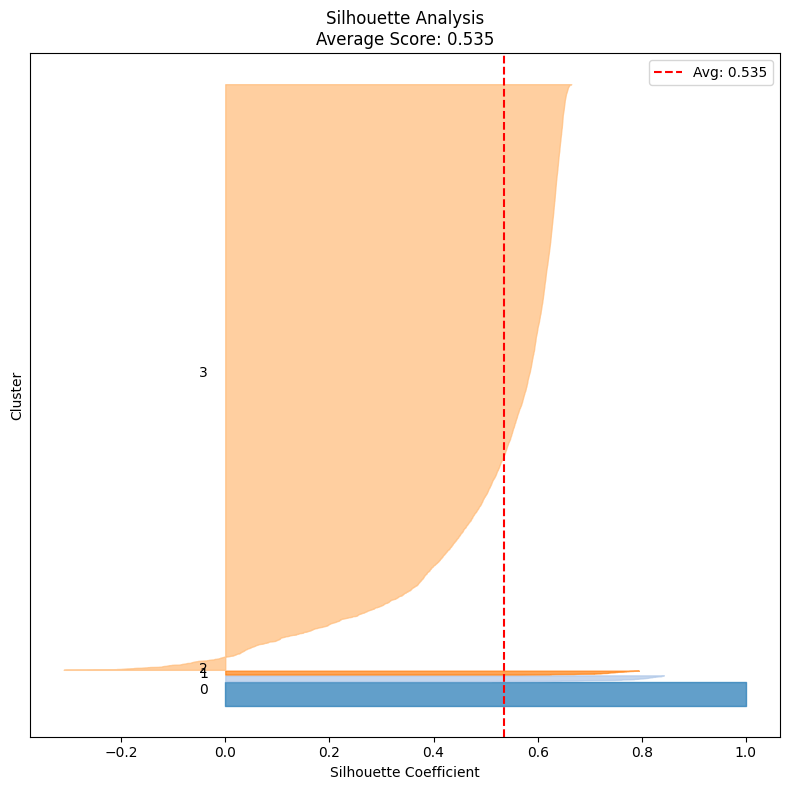


📊 CLUSTERING COMPARISON SUMMARY

source  n_clusters  n_noise  silhouette  davies_bouldin  calinski_harabasz
    GT           4     1157    0.535004        0.457235        1413.678696

📖 Interpretation Guide:
  • Silhouette Score: Closer to 1 = better separated clusters
  • Davies-Bouldin: Lower = better cluster separation
  • Calinski-Harabasz: Higher = better defined clusters
  • Noise %: Lower might be better, but depends on data quality


In [100]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# LOAD CLUSTERED DATA
# =========================

CLUSTERED_FILES = [
    ("output/gt_indexed_chunk_features.parquet", "GT")
    # Note: Using in-memory dataframe 'df' from clustering cell above
]

evaluation_results = []

# Use the 'df' from clustering cell if available, otherwise load from parquet
if 'df' in globals() and 'cluster_id' in df.columns:
    print(f"\n{'='*60}")
    print(f"Evaluating Clustering Results")
    print(f"{'='*60}\n")
    
    source_name = "GT"
    print(f"Using in-memory data (from clustering cell): {len(df)} rows")
    print(f"Columns: {list(df.columns)}")
    
    # Check if clustering has been performed
    if 'cluster_id' not in df.columns:
        print(f"⚠️ No clustering results found. The 'cluster_id' column is missing.")
        print(f"   Please run the clustering cell first.")
    else:
        # Prepare feature matrix
        feature_cols = [
            'char_len', 'word_len', 'line_count', 'avg_line_len',
            'table_density', 'latex_ratio', 'numeric_ratio', 'non_alpha_ratio',
            'avg_word_length', 'text_alpha_ratio', 'stopword_ratio', 'lexical_diversity'
        ]
        
        # Standardize features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X = scaler.fit_transform(df[feature_cols])
        
        labels = df['cluster_id'].values
        
        # Separate clustered points from noise
        mask_clustered = labels != -1
        X_clustered = X[mask_clustered]
        labels_clustered = labels[mask_clustered]
        
        n_clusters = len(set(labels_clustered))
        n_noise = (labels == -1).sum()
        n_total = len(labels)
        
        print(f"\n📊 Clustering Summary:")
        print(f"  Total points: {n_total}")
        print(f"  Clusters: {n_clusters}")
        print(f"  Noise points: {n_noise} ({100*n_noise/n_total:.1f}%)")
        
        # Compute metrics
        results = {"source": source_name, "n_clusters": n_clusters, "n_noise": n_noise}
        
        if n_clusters >= 2:
            sil_score = silhouette_score(X_clustered, labels_clustered)
            db_score = davies_bouldin_score(X_clustered, labels_clustered)
            ch_score = calinski_harabasz_score(X_clustered, labels_clustered)
            
            results.update({
                "silhouette": sil_score,
                "davies_bouldin": db_score,
                "calinski_harabasz": ch_score
            })
            
            print(f"\n📈 Quality Metrics:")
            print(f"  Silhouette Score: {sil_score:.3f}")
            print(f"  Davies-Bouldin Score: {db_score:.3f}")
            print(f"  Calinski-Harabasz Score: {ch_score:.1f}")
            
            # Silhouette plot
            sil_samples = silhouette_samples(X_clustered, labels_clustered)
            
            fig, ax = plt.subplots(figsize=(8, 8))
            y_lower = 10
            
            for cluster_id in sorted(set(labels_clustered)):
                cluster_sil_vals = sil_samples[labels_clustered == cluster_id]
                cluster_sil_vals.sort()
                
                size_cluster = cluster_sil_vals.shape[0]
                y_upper = y_lower + size_cluster
                
                color = plt.cm.tab20(cluster_id % 20)
                ax.fill_betweenx(np.arange(y_lower, y_upper),
                                0, cluster_sil_vals,
                                facecolor=color, edgecolor=color, alpha=0.7)
                
                ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster_id))
                y_lower = y_upper + 10
            
            ax.set_title(f"Silhouette Analysis\nAverage Score: {sil_score:.3f}")
            ax.set_xlabel("Silhouette Coefficient")
            ax.set_ylabel("Cluster")
            ax.axvline(x=sil_score, color="red", linestyle="--", label=f"Avg: {sil_score:.3f}")
            ax.legend()
            ax.set_yticks([])
            
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"\n⚠️ Not enough clusters for metric calculation (need at least 2 clusters)")
        
        evaluation_results.append(results)

# =========================
# COMPARISON SUMMARY
# =========================

if len(evaluation_results) > 0:
    print(f"\n{'='*60}")
    print("📊 CLUSTERING COMPARISON SUMMARY")
    print(f"{'='*60}\n")
    
    comparison_df = pd.DataFrame(evaluation_results)
    print(comparison_df.to_string(index=False))
    
    # Interpretation guide
    print(f"\n📖 Interpretation Guide:")
    print(f"  • Silhouette Score: Closer to 1 = better separated clusters")
    print(f"  • Davies-Bouldin: Lower = better cluster separation")
    print(f"  • Calinski-Harabasz: Higher = better defined clusters")
    print(f"  • Noise %: Lower might be better, but depends on data quality")


### Detailed Cluster Quality Assessment

Advanced analysis of cluster quality and stability:
- Cluster size distribution and balance
- Per-cluster quality metrics (silhouette, cohesion)
- Cluster stability analysis
- Visualization of cluster characteristics
- Identification of weak/unstable clusters

✅ Cluster results found in memory. Performing detailed evaluation...

📊 Cluster Size Distribution:

cluster_id
0     303
1      74
2      50
3    7470

Noise points: 1157

📈 Cluster Balance Metrics:
  Avg cluster size: 1974.2
  Min cluster size: 50
  Max cluster size: 7470
  Std deviation: 3665.61
  Max/Min ratio: 149.40

📊 Cluster distribution plot generated (not saved to disk)


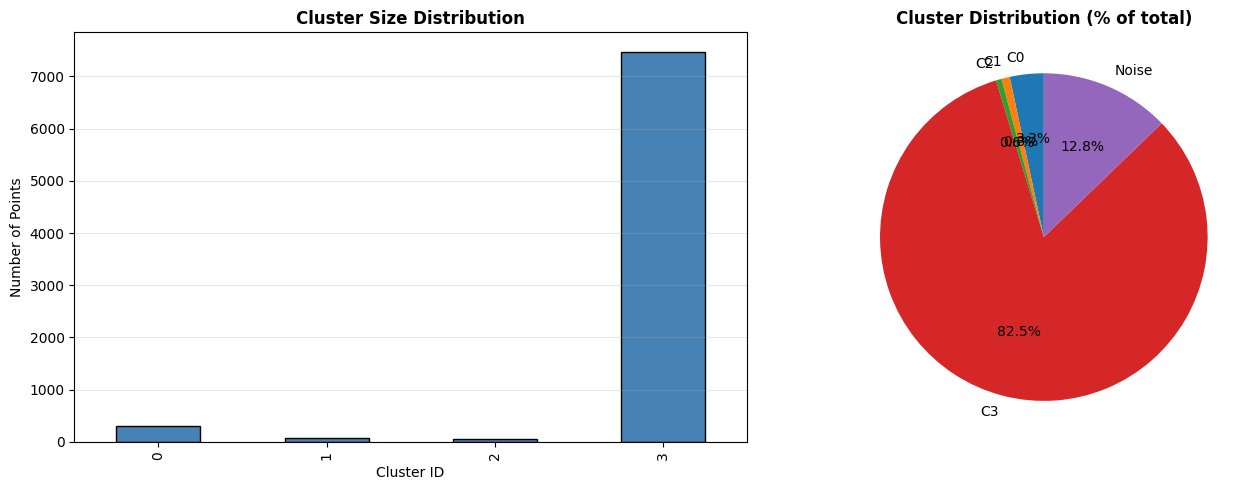


🔍 Feature Statistics by Cluster:

  char_len:
               mean      std   min    max
cluster_id                               
0              0.00     0.00     0      0
1           6018.82  3386.49   457  20241
2           2866.20  1067.52  1053   5259
3           2881.84  1936.59    10  26463

  word_len:
              mean     std  min   max
cluster_id                           
0             0.00    0.00    0     0
1            96.28   55.30    6   350
2           370.08  132.33  164   643
3           459.49  315.00    2  4739

  line_count:
              mean    std  min  max
cluster_id                         
0             0.00   0.00    0    0
1           112.95  64.63    7  359
2            36.54  13.77   13   71
3            27.52  25.88    1  243


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# =========================
# LOAD AND ANALYZE CLUSTERS
# =========================

if 'df' in globals() and 'cluster_id' in df.columns:
    print("✅ Cluster results found in memory. Performing detailed evaluation...\n")
    
    # =========================
    # CLUSTER SIZE DISTRIBUTION
    # =========================
    
    print("📊 Cluster Size Distribution:")
    cluster_sizes = df[df['cluster_id'] != -1]['cluster_id'].value_counts().sort_index()
    noise_count = (df['cluster_id'] == -1).sum()
    
    print(f"\n{cluster_sizes.to_string()}")
    print(f"\nNoise points: {noise_count}")
    
    # =========================
    # CLUSTER BALANCE ANALYSIS
    # =========================
    
    total_clustered = cluster_sizes.sum()
    if total_clustered > 0:
        print(f"\n📈 Cluster Balance Metrics:")
        print(f"  Avg cluster size: {cluster_sizes.mean():.1f}")
        print(f"  Min cluster size: {cluster_sizes.min()}")
        print(f"  Max cluster size: {cluster_sizes.max()}")
        print(f"  Std deviation: {cluster_sizes.std():.2f}")
        imbalance_ratio = cluster_sizes.max() / cluster_sizes.min() if cluster_sizes.min() > 0 else np.inf
        print(f"  Max/Min ratio: {imbalance_ratio:.2f}")
    
    # =========================
    # VISUALIZE CLUSTER DISTRIBUTION
    # =========================
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Cluster sizes bar chart
    cluster_sizes.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
    axes[0].set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Cluster ID')
    axes[0].set_ylabel('Number of Points')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie chart of cluster proportions
    labels = [f"C{i}" for i in cluster_sizes.index]
    sizes = cluster_sizes.values
    if noise_count > 0:
        labels.append("Noise")
        sizes = np.append(sizes, noise_count)
    
    axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Cluster Distribution (% of total)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()

    print(f"\n📊 Cluster distribution plot generated (not saved to disk)")
    plt.show()
    
    # =========================
    # CLUSTER FEATURE STATISTICS
    # =========================
    
    print(f"\n🔍 Feature Statistics by Cluster:")
    feature_cols = [
        'char_len', 'word_len', 'line_count', 'avg_line_len',
        'table_density', 'latex_ratio', 'numeric_ratio'
    ]
    
    clustered_df = df[df['cluster_id'] != -1]
    for feature in feature_cols[:3]:  # Show first 3 features
        cluster_stats = clustered_df.groupby('cluster_id')[feature].agg(['mean', 'std', 'min', 'max'])
        print(f"\n  {feature}:")
        print(cluster_stats.round(2).to_string())
    
    # =========================
    # SAVE CLUSTER STATISTICS (disabled - keep in memory only)
    # =========================
    
    cluster_stats_df = df.groupby('cluster_id').agg({
        'char_len': ['mean', 'std'],
        'word_len': ['mean', 'std'],
        'line_count': ['mean', 'std'],
        'table_density': ['mean', 'std'],
        'latex_ratio': ['mean', 'std']
    }).round(3)
    
    
else:
    print("⚠️ No clustering results found in memory.")
    print("Please run the clustering cell first.")


### Reconstruct Clean Chunks to JSON

This cell converts the cleaned parquet file back to the original JSON format:
- Loads the cleaned chunks from `gt_indexed_chunk_clean.parquet`
- Reconstructs the JSON structure with text and metadata
- Saves as `gt_indexed_chunk_clean.json` for use in retrieval experiments

This is necessary because the retrieval pipeline expects JSON input files.

In [102]:
import pandas as pd
import json
from pathlib import Path

# ---------- Reconstruct JSON from cleaned dataframe ----------
print("Reconstructing JSON from cleaned dataframe")

if 'clean_df' in globals():
    df = clean_df
    print(f"\nLoaded {len(df)} clean chunks from memory")
    
    # ---------- Reconstruct JSON structure ----------
    json_list = []
    for _, row in df.iterrows():
        item = {
            "subdir": row.get("subdir", "default") if hasattr(row, "get") else row.get("subdir", "default") if isinstance(row, dict) else getattr(row, "subdir", "default"),
            "text": row.get("text_full", row.get("text_preview", "")) if hasattr(row, "get") else row.get("text_full", row.get("text_preview", "")) if isinstance(row, dict) else (getattr(row, "text_full", None) or getattr(row, "text_preview", "")),
            "metadata": {
                "page_idx": int(row.get("page_idx", -1)) if hasattr(row, "get") else int(row.get("page_idx", -1)) if isinstance(row, dict) else int(getattr(row, "page_idx", -1)),
                "file_path": row.get("file_path", "") if hasattr(row, "get") else row.get("file_path", "") if isinstance(row, dict) else getattr(row, "file_path", ""),
                "file_name": row.get("file_name", "") if hasattr(row, "get") else row.get("file_name", "") if isinstance(row, dict) else getattr(row, "file_name", ""),
                "file_type": row.get("file_type", "application/json") if hasattr(row, "get") else row.get("file_type", "application/json") if isinstance(row, dict) else getattr(row, "file_type", "application/json"),
                "file_size": int(row.get("file_size", 0)) if hasattr(row, "get") else int(row.get("file_size", 0)) if isinstance(row, dict) else int(getattr(row, "file_size", 0)),
                "creation_date": row.get("creation_date", "") if hasattr(row, "get") else row.get("creation_date", "") if isinstance(row, dict) else getattr(row, "creation_date", ""),
                "last_modified_date": row.get("last_modified_date", "") if hasattr(row, "get") else row.get("last_modified_date", "") if isinstance(row, dict) else getattr(row, "last_modified_date", ""),
                "last_accessed_date": row.get("last_accessed_date", "") if hasattr(row, "get") else row.get("last_accessed_date", "") if isinstance(row, dict) else getattr(row, "last_accessed_date", "")
            }
        }
        json_list.append(item)
    
  
    print(f"\n✅ Reconstructed JSON stored in memory")
    print(f"   Contains {len(json_list)} items")
    
else:
    print("⚠️ 'clean_df' not found in memory. Please run clustering cell first.")


Reconstructing JSON from cleaned dataframe

Loaded 7897 clean chunks from memory

✅ Reconstructed JSON stored in memory
   Contains 7897 items


### Retrieval Comparison Pipeline

This cell compares retrieval performance between the original GT chunks and the cleaned GT chunks by:
- Loading indexed chunks from JSON files
- Reconstructing document structure in temporary directories
- Running BM25 retrieval for each question in the dataset
- Using the built-in RetrievalTask scoring to properly evaluate all retrieved chunks
- Computing overall metrics (LCS, precision, etc.)
- Saving detailed results to JSON files for later analysis

The pipeline runs twice: once for original data (`retrieval_gt.json`) and once for cleaned data (`retrieval_gt_clean.json`).

In [103]:
import os
import json
import tempfile
import shutil
from pathlib import Path
from tqdm import tqdm


# =========================
# CONFIG
# =========================

QA_PATH = Path("data/qas_v2.json")

TOP_K = 2
CHUNK_SIZE = 1024
CHUNK_OVERLAP = 0


# =========================
# HELPERS
# =========================

def load_qas(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return list(data.values()) if isinstance(data, dict) else data


def group_and_write(chunks, temp_root):
    """
    Reconstruct chunks into per-document JSON files
    so CustomBM25Retriever can index them
    """
    groups = {}

    for ch in chunks:
        meta = ch.get("metadata", {})
        file_name = meta.get("file_name") or meta.get("file_path") or "unknown"
        basename = os.path.splitext(os.path.basename(file_name))[0]

        groups.setdefault(basename, []).append({
            "text": ch.get("text", ""),
            "page_idx": meta.get("page_idx"),
            "file_name": basename
        })

    for basename, records in groups.items():
        with open(Path(temp_root) / f"{basename}.json", "w", encoding="utf-8") as f:
            json.dump(records, f, ensure_ascii=False)


# =========================
# CORE RETRIEVAL + EVAL
# =========================

def run_retrieval(chunks_data, ocr_type):
    """
    Run retrieval task on chunks data (can be in-memory list or file path)
    Returns results dictionary instead of saving to file
    """
    print(f"\n===== Running retrieval: {ocr_type} =====")

    # Load chunks - handle both file path and in-memory list
    if isinstance(chunks_data, str):
        with open(chunks_data, "r", encoding="utf-8") as f:
            chunks = json.load(f)
    else:
        chunks = chunks_data
    
    print(f"[DEBUG] Loaded {len(chunks)} chunks")

    # Load QA set
    qas = load_qas(QA_PATH)
    print(f"[DEBUG] Loaded {len(qas)} QA items")

    # Temp index dir
    tmp_dir = tempfile.mkdtemp(prefix=f"{ocr_type}_idx_")

    try:
        # Rebuild docs
        group_and_write(chunks, tmp_dir)

        # Retriever
        retriever = CustomBM25Retriever(
            tmp_dir,
            chunk_size=CHUNK_SIZE,
            chunk_overlap=CHUNK_OVERLAP,
            similarity_top_k=TOP_K
        )

        # RetrievalTask (for aggregation and scoring)
        llm = Mock()
        task = RetrievalTask(output_dir="memory")  # Use memory mode instead of file output
        task.set_model(llm, retriever)

        results = []

        for qa in tqdm(qas, desc=f"Retrieving ({ocr_type})"):
            # Build data_point structure expected by task
            data_point = qa.copy()
            
            try:
                # Use task's retrieve_docs method
                retrieval_results = task.retrieve_docs(data_point)
                data_point["retrieval_results"] = retrieval_results
                
                # Use task's built-in scoring (properly calculates LCS with all retrieved chunks)
                result = {'id': data_point['ID'], **task.scoring(data_point)}
                results.append(result)
                
            except Exception as e:
                print(f"[ERROR] Processing {data_point.get('ID', 'unknown')}: {e}")
                data_point["retrieval_results"] = []
                result = {'id': data_point['ID'], **task.scoring(data_point)}
                results.append(result)

        # =========================
        # AGGREGATE METRICS
        # =========================

        valid_results = [r for r in results if r["valid"]]
        overall = task.compute_overall(valid_results)

        print("\nOverall Metrics:")
        for k, v in overall.items():
            print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

        # =========================
        # RETURN RESULTS (instead of saving)
        # =========================

        output = {
            "info": {
                "task": "RetrievalTask",
                "retriever": "CustomBM25Retriever",
                "ocr_type": ocr_type,
                "retrieve_top_k": TOP_K,
                "chunk_size": CHUNK_SIZE,
                "chunk_overlap": CHUNK_OVERLAP
            },
            "overall": overall,
            "results": results
        }

        
        print(f"✅ Results stored in memory (retrieval_output variable)")
        return output

    finally:
        shutil.rmtree(tmp_dir, ignore_errors=True)


# =========================
# RUN EXPERIMENTS
# =========================

if 'json_list' in globals():
    print("Using in-memory json_list from reconstruction cell")
    retrieval_output = run_retrieval(json_list, "gt_clean")
else:
    print("⚠️ json_list not found. Please run reconstruction cell first.")


Using in-memory json_list from reconstruction cell

===== Running retrieval: gt_clean =====
[DEBUG] Loaded 7897 chunks
[DEBUG] Loaded 8498 QA items
Indexing finished for all directories!


Retrieving (gt_clean): 100%|██████████| 8498/8498 [07:03<00:00, 20.08it/s] 



Overall Metrics:
  avg. lcs: 0.3807
  num: 8498
✅ Results stored in memory (retrieval_output variable)
